# Time Constructions

Towards a usage-based, constructional taxonomy of time indicators in Biblical Hebrew.

In [2]:
import collections
import pandas as pd
import seaborn as sns
sns.set(font_scale=1.5, style='whitegrid')
import matplotlib.pyplot as plt
from tf.fabric import Fabric
from tf.app import use

custom_data = ['/Users/cody/text-fabric-data/etcbc/bhsa/tf/c',
               '/Users/cody/github/etcbc/heads/tf/c',
               '../data/',
               '../data/funct_associations/'
              ]

TF = Fabric(locations=custom_data)
api = TF.load('''

vs vt pdp gloss lex language 
rela typ number function
g_cons_utf8 nu mother st uvf
head nhead obj_prep sem_set
ls topAssoc TimeAssoc LocaAssoc
label semrole
''')

A = use('bhsa', api=api, hoist=globals(), silent=True)

A.displaySetup(condenseType='clause', condensed=True, withNodes=True)

This is Text-Fabric 7.4.11
Api reference : https://annotation.github.io/text-fabric/Api/Fabric/

142 features found and 4 ignored
  0.00s loading features ...
   |     0.17s B g_cons_utf8          from /Users/cody/text-fabric-data/etcbc/bhsa/tf/c
   |     0.13s B lex                  from /Users/cody/text-fabric-data/etcbc/bhsa/tf/c
   |     0.13s B vs                   from /Users/cody/text-fabric-data/etcbc/bhsa/tf/c
   |     0.16s B vt                   from /Users/cody/text-fabric-data/etcbc/bhsa/tf/c
   |     0.12s B pdp                  from /Users/cody/text-fabric-data/etcbc/bhsa/tf/c
   |     0.13s B gloss                from /Users/cody/text-fabric-data/etcbc/bhsa/tf/c
   |     0.13s B language             from /Users/cody/text-fabric-data/etcbc/bhsa/tf/c
   |     0.20s B rela                 from /Users/cody/text-fabric-data/etcbc/bhsa/tf/c
   |     0.27s B typ                  from /Users/cody/text-fabric-data/etcbc/bhsa/tf/c
   |     0.25s B number               from /Users

In [3]:
def findLex(lex_str):
    '''
    Finds a lex node.
    '''
    return [(l, F.gloss.v(l), F.lex.v(l)) 
                for l in F.otype.s('lex')
                if lex_str == F.lex.v(l)]


# map lexeme 2 surface forms here
lex2token = {}

# map def article to ה (for cases of unconsonantal versions)
lex2token[1437572] = 'ה'

# map cardinals to מ׳׳
for lex in F.otype.s('lex'):
    if F.ls.v(lex) == 'card':
        lex2token[lex] = 'מ׳׳'

def tokenWord(wordnode, lex_mapping=lex2token):
    '''
    Tokenizes a word. If lexeme is mapped,
    uses mapped string. Otherwise uses g_cons_utf8
    '''
    lex = L.u(wordnode, 'lex')[0]
    return lex2token.get(lex, F.g_cons_utf8.v(wordnode))

def tokenPhrase(phrasenode, wordTokener=tokenWord):
    '''
    Tokenizes a phrase with
    dot-separated words.
    input: phrase node number
    output: token string
    '''
    words = [wordTokener(w) for w in L.d(phrasenode, 'word')]
    return '.'.join(words)

## Measuring Time Phrase Dispersion

This analysis of time constructions is based on frequency. In a usage-based approach to language, highly frequent terms are the prototypes which other structures in the language are based on. In the analysis of time constructions, the top occurring surface forms, or tokens, are proposed to represent the primary means of representing time. However, raw frequencies can be misleading. For this reason, we apply a frequency adjustment as suggested by Stefan Gries.

In [4]:
time_tokens = collections.defaultdict(lambda:collections.Counter())
token2results = collections.defaultdict(list)


times = A.search('''

phrase function=Time
    word language=Hebrew lex#>K|>Z|<TH

''', shallow=True)

for tp in times:
    book, chapter, verse = T.sectionFromNode(tp)
    time_tokens[book][tokenPhrase(tp)] += 1
    token2results[tokenPhrase(tp)].append((tp,))
    
time_tokens = pd.DataFrame(time_tokens).fillna(0)

  1.79s 3540 results


In [5]:
time_tokens.shape

(1049, 39)

In [6]:
pd.DataFrame(time_tokens.sum(1).sort_values(ascending=False)).head(20)

,0
ב.ה.יום.ה.הוא,205.0
ה.יום,192.0
מ׳׳.ימים,96.0
ל.עולם,87.0
ב.ה.בקר,79.0
עד.ה.יום.ה.זה,73.0
ב.יום,69.0
עד.עולם,53.0
מ׳׳.שׁנים,47.0
אחרי.כן,47.0


### Calculate Degree of Dispersion *DP*

In [7]:
# count all phrase tokens in all books
phrase_tokens = collections.defaultdict(lambda:collections.Counter())

for phrase in F.otype.s('phrase'):
    book, chapter, verse = T.sectionFromNode(phrase)
    phrase_tokens[book][tokenPhrase(phrase)] += 1
    
phrase_tokens = pd.DataFrame(phrase_tokens).fillna(0)

phrase_tokens.shape

(55843, 39)

In [8]:
expected_prop = phrase_tokens.sum() / phrase_tokens.sum().sum()
observed_prop = time_tokens.div(time_tokens.sum(1), axis=0)
prop_diffs = abs(expected_prop-observed_prop)
dp = 1-pd.DataFrame(prop_diffs.sum(1) / 2, columns=['DP'])

In [9]:
time_dp_total = pd.concat((dp, time_tokens.sum(1)), axis=1)
time_dp_total.columns = ('DP', 'Total')
time_dp_total = time_dp_total[['Total', 'DP']]

time_dp_total.sort_values(by='Total', ascending=False).head(20)

,Total,DP
ב.ה.יום.ה.הוא,205.0,0.555638
ה.יום,192.0,0.511557
מ׳׳.ימים,96.0,0.477761
ל.עולם,87.0,0.434959
ב.ה.בקר,79.0,0.617769
עד.ה.יום.ה.זה,73.0,0.504648
ב.יום,69.0,0.582046
עד.עולם,53.0,0.486692
אחרי.כן,47.0,0.557250
מ׳׳.שׁנים,47.0,0.526508


In [10]:
dp.sort_values(ascending=False, by='DP').head(20)

,DP
ב.ה.בקר,0.617769
לילה,0.587923
ב.יום,0.582046
אחרי.כן,0.557250
ב.ה.יום.ה.הוא,0.555638
מ׳׳.שׁנים,0.526508
מ׳׳.שׁנה,0.524281
ה.יום,0.511557
עד.ה.יום.ה.זה,0.504648
ב.ה.ימים.ה.הם,0.496710


Text(0.5, 1.0, 'DP Score by Token Rank')

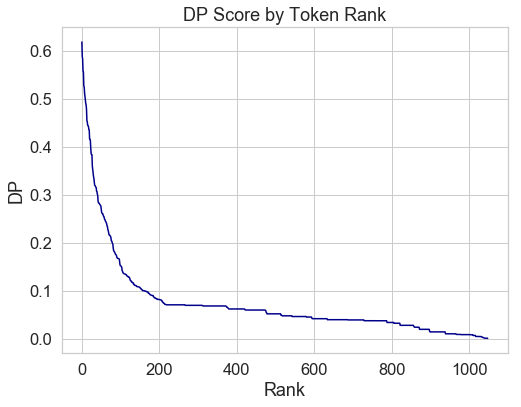

In [11]:
plt.figure(figsize=(8,6))
plt.plot(sorted(dp.values, reverse=True), color='darkblue')
plt.xlabel('Rank', size=18)
plt.ylabel('DP', size=18)
plt.title('DP Score by Token Rank')

Text(0.5, 1.0, 'Token Frequency by Rank')

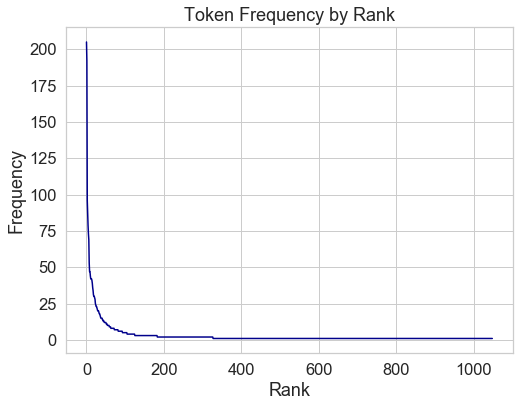

In [12]:
plt.figure(figsize=(8,6))
plt.plot(sorted(time_tokens.sum(1).values, reverse=True), color='darkblue')
plt.xlabel('Rank', size=18)
plt.ylabel('Frequency', size=18)
plt.title('Token Frequency by Rank')

## Querying Constructions

Attempting to describe the most productive constructions.

In [13]:
total_times = len(times)
time_cxs = collections.defaultdict(list)
time_cxs_prop = collections.defaultdict(float)

### 1. prep + H + timeNoun + H + demonstrative

The ב.ה.יום.ה.הוא construction is the most common with a relatively high DP score of (0.56), and there are numerous similar variants of this construction. Below I aim to represent this construction abstractly, with each of the pieces constructed with parts of speech fillers. I want to see how much of the data this construction accounts for, and I want to compare its distribution and use accross other categories and functions. 

In [14]:
demon_cx = A.search('''

phrase function=Time
    word sem_set=prep language=Hebrew
    <: word lex=H
    <: word pdp=subs
    <: word lex=H
    <: word pdp=prde

''')
dcx_name = 'prep + H + timeNoun + H + demonstrative'

time_cxs[dcx_name] = demon_cx

dcx_ct = len(set(res[0] for res in demon_cx))
dcx_prop = round(dcx_ct/total_times, 2)
time_cxs_prop[dcx_name] = dcx_prop

print()
print(f'accounts for {dcx_ct}/{total_times} \t {dcx_prop}')

  3.09s 480 results

accounts for 476/3540 	 0.13


In [15]:
# A.show(demon_cx)

### 2. H + timeNoun

In [26]:
the_cx = A.search('''

p:phrase function=Time
    =: word lex=H language=Hebrew
    <: w1:word pdp=subs
p := w1

''')

the_cx_name = 'H + timeNoun'

time_cxs[the_cx_name] = the_cx

thecx_ct = len(set(res[0] for res in the_cx))
thecx_prop = round(thecx_ct/total_times, 2)
time_cxs_prop[the_cx_name] = thecx_prop

print()
print(f'accounts for {thecx_ct}/{total_times} \t {thecx_prop}')

  1.55s 217 results

accounts for 217/3540 	 0.06


In [27]:
A.show(the_cx, condenseType='sentence', extraFeatures='st')

Get an update on progress:

In [16]:
sum(time_cxs_prop.values())

0.19

### 3. Quantified Constructions (מ׳׳)

Time constructions with quantifiers seem to inherit the quantified NP construction, and there are thus relatively complex chains that are formed. These constructions are pre-processed into quantifier constructions in [quantifier_constructions.ipynb](preprocessing/quantifier_constructions.ipynb). The result is a new object, constructions, and constructions with a label of 'quantified_NP' are base units of constructions.

#### Count Quantifier Construction Types

In [78]:
quant_cx = A.search('''

phrase function=Time
    <nhead- word pdp=subs
    word ls=card language=Hebrew

''', shallow=True)

tok2res = collections.defaultdict(list)

def tokenQuants(phrasenode):
    words = list(L.d(phrasenode, 'word'))
    token = []
    i = 0 
    while i < len(words):
        
        word = words[i]
        i += 1
        
        # replace quantified cx
        if L.u(word, 'construction'):
            
            top_cx = sorted((len(L.d(cx, 'word')), cx)
                                for cx in L.u(word, 'construction')
                                if 'quantified_NP' in F.label.v(cx))[-1][1]
            token.append('מ׳׳')
            i += len(L.d(top_cx, 'word'))-1
            
        elif F.lex.v(word) == 'H':
            token.append('ה')
            
        elif F.ls.v(word) == 'card':
            token.append('מ׳׳')
            
        else:
            token.append(F.g_cons_utf8.v(word))
            
    return '.'.join(token)
            
count_quants = collections.Counter()
    
for ph in quant_cx:
    ph_token = tokenQuants(ph)
    count_quants[ph_token] += 1
    tok2res[ph_token].append((ph,))

  1.75s 603 results


In [79]:
#A.show(tok2res['ב.מ׳׳.ה.חדשׁ'], extraFeatures='st', condenseType='sentence')

In [80]:
pd.DataFrame(count_quants.most_common())

,0,1
0,מ׳׳,319
1,ב.מ׳׳,27
2,ב.מ׳׳.ל.ה.חדשׁ,21
3,מ׳׳.ו.מ׳׳,14
4,מ.קץ.מ׳׳,13
5,מ.קצה.מ׳׳,9
6,ב.שׁנת.מ׳׳.ל.אסא.מלך.יהודה,8
7,ל.מ׳׳,7
8,ב.שׁנת.מ׳׳,7
9,מ׳׳.ב.ה.שׁנה,5


In [84]:
b_l_time = A.search('''

phrase function=Time
    word lex=B
    < construction label=quantified_NP|quantified_NP+quantified_NP
    /without/
    construction
        ..
    /-/
    <: word lex=L

''')

  0.49s 88 results


In [87]:
A.show(b_l_time)